In [35]:
import os, shutil, pathlib
#satlux
#wisenut

## 데이터 경로, 폴더 나눠서 만들기

In [37]:
original_dir = pathlib.Path('./dogs-vs-cats/train')
new_base_dir = pathlib.Path('./dogs-vs-cats/cats_vs_dogs_small')

def make_subset(subset_name, start_index, end_index) :
    for category in ('cat', 'dog') :
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
    
        for fname in fnames :
            shutil.copyfile(src=original_dir / fname,
                        dst=dir / fname)
        
make_subset('train', start_index = 0, end_index = 1000)
make_subset('validation', start_index = 1000, end_index = 1500)
make_subset('test', start_index = 1500, end_index = 2500)

## 모델 생성

In [38]:
from tensorflow import keras
from tensorflow.keras import layers

### 강아지 vs 고양이 분류를 위한 소규모 컨브넷 만들기

In [39]:
inputs = keras.Input(shape=(180, 180, 3)) # 이모델은 180*180 크기의 RGB이미지 기대

x = layers.Rescaling(1./255)(inputs)      # 입력을 255로 나누어[0,1] 범위로 스케일을 조정

x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### 특성맴 Feature Mpb 확인

In [40]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

## 모델 훈련 설정하기 (优化器)

In [41]:
model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

## 데이터 전처리
  1. img load
  2. jpeg를 RGB 픽셀값으로 디코딩
  3. 부동 소수점 타입의 텐서로 변환
  4. 동일한 크기의 이미지로 바꿈(180 x 180을 사용)
  5. 배치로 붂음(하나의 배치의 배치는 32개의 이미지로 구성됨)
  
  - **image_dataset_from_directory()** 케라스에서 제공
  - directory의 서브리렉터리를 찾고 각 서브디렉터리에 있는 이미지 파일을 인덱싱 하고
  - 파일 읽고, 순서를 섞고, 텐서 디코-> 동일 크기로 변공 -> 배치로 묶어주는 **tf.data.Dataset 만들어짐**

In [42]:
from tensorflow.keras.utils import image_dataset_from_directory

In [43]:
train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation', 
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [44]:
for data_batch, labels_batch in train_dataset :
    print('데이터 배치 크기 :', data_batch.shape)
    print('레이블 배치 크기 :', labels_batch.shape)
    break

데이터 배치 크기 : (32, 180, 180, 3)
레이블 배치 크기 : (32,)


## dataset으로 모델 훈련하기

In [45]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_scratch.keras',
        save_best_only = True,
        monitor='val_loss')
]

history = model.fit(train_dataset,
                    epochs = 30,
                    validation_data = validation_dataset,
                    callbacks = callbacks)

Epoch 1/30
63/63 [==============================] - 57s 889ms/step - loss: 0.7011 - accuracy: 0.5235 - val_loss: 0.6884 - val_accuracy: 0.5180
Epoch 2/30
63/63 [==============================] - 67s 1s/step - loss: 0.6923 - accuracy: 0.5670 - val_loss: 0.6819 - val_accuracy: 0.5610
Epoch 3/30
63/63 [==============================] - 66s 1s/step - loss: 0.6801 - accuracy: 0.6055 - val_loss: 0.6207 - val_accuracy: 0.6420
Epoch 4/30
63/63 [==============================] - 64s 1s/step - loss: 0.6238 - accuracy: 0.6415 - val_loss: 0.6180 - val_accuracy: 0.6410
Epoch 5/30
63/63 [==============================] - 67s 1s/step - loss: 0.5880 - accuracy: 0.6975 - val_loss: 0.6515 - val_accuracy: 0.6420
Epoch 6/30
63/63 [==============================] - 65s 1s/step - loss: 0.5602 - accuracy: 0.6950 - val_loss: 0.7410 - val_accuracy: 0.6260
Epoch 7/30
63/63 [==============================] - 65s 1s/step - loss: 0.5291 - accuracy: 0.7365 - val_loss: 0.6125 - val_accuracy: 0.6750
Epoch 8/30
63/63 

## 훈련 과정의 정확도와 손실 그래프 그리기

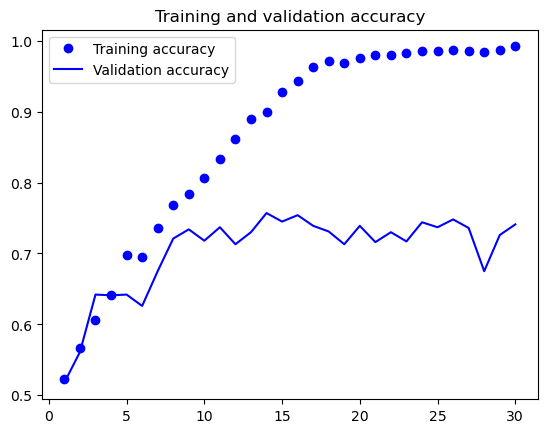

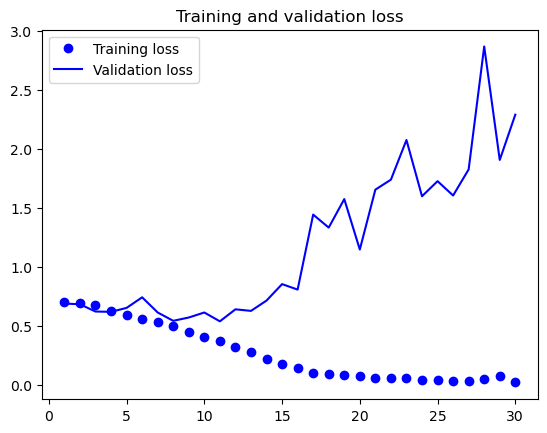

In [47]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [48]:
3*3*32+32

320